In [5]:
from torch.utils.data import Dataset
from botdet.data.dataloader import GraphDataLoader
import deepdish as dd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch as ch
import random
import numpy as np
import dgl

In [2]:
METADATA_FILE_PATH = "coeffs.csv"
prefix = "/localtmp/as9rw/datasets/botnet_temp/"

In [120]:
# Load metadata file
names, values = [], []
nam_val_map = {}
with open(METADATA_FILE_PATH, 'r') as f:
    for line in f:
        n, v = line.rstrip("\n").split(',')
        names.append("/" + n)
        values.append(float(v))
        nam_val_map[names[-1]] = values[-1]
    names = np.array(names)
    values = np.array(values)

(array([26., 29., 52., 87., 65., 62., 46., 57., 55.,  9.]),
 array([0.00334518, 0.00405657, 0.00476795, 0.00547934, 0.00619073,
        0.00690211, 0.0076135 , 0.00832489, 0.00903627, 0.00974766,
        0.01045905]),
 <a list of 10 Patch objects>)

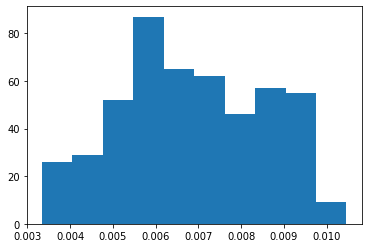

In [121]:
plt.hist(values)

In [122]:
prefixes = list(set([x[:24] for x in names]))
month_wise = [[] for _ in prefixes]
month_innernames = [[] for _ in prefixes]
for n, v in zip(names, values):
    month_wise[prefixes.index(n[:24])].append(v)
    month_innernames[prefixes.index(n[:24])].append(n)
month_wise = np.array(month_wise)
month_innernames = np.array(month_innernames)

In [125]:
# Use first X% per month as victim ,remaining (100-X)% as adv
sp = 40
victim_names = np.concatenate([x[:sp] for x in month_innernames])
adv_names = np.concatenate([x[sp:] for x in month_innernames])

victim_vals = np.array([nam_val_map[x] for x in victim_names])
adv_vals = np.array([nam_val_map[x] for x in adv_names])

(array([15., 22., 25., 67., 34., 43., 28., 27., 45., 14.]),
 array([0.00337397, 0.00405855, 0.00474312, 0.0054277 , 0.00611227,
        0.00679685, 0.00748142, 0.008166  , 0.00885057, 0.00953515,
        0.01021972]),
 <a list of 10 Patch objects>)

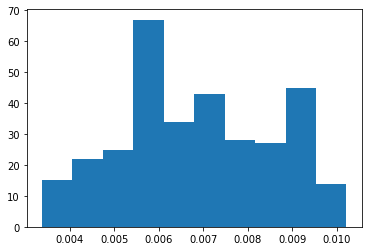

In [126]:
plt.hist(victim_vals, bins=10)

(array([15., 22., 25., 67., 34., 43., 28., 27., 45., 14.]),
 array([0.00337397, 0.00405855, 0.00474312, 0.0054277 , 0.00611227,
        0.00679685, 0.00748142, 0.008166  , 0.00885057, 0.00953515,
        0.01021972]),
 <a list of 10 Patch objects>)

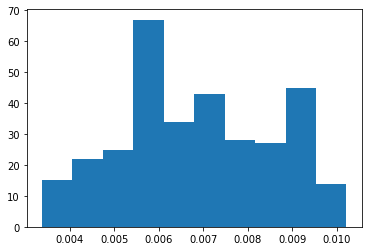

In [62]:
plt.hist(victim, bins=10)

(array([12.,  6., 19., 24., 30., 17., 21., 18., 17.,  4.]),
 array([0.00334518, 0.00405657, 0.00476795, 0.00547934, 0.00619073,
        0.00690211, 0.0076135 , 0.00832489, 0.00903627, 0.00974766,
        0.01045905]),
 <a list of 10 Patch objects>)

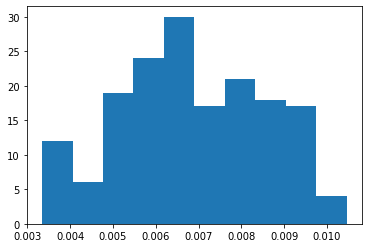

In [63]:
plt.hist(adv, bins=10)

In [167]:
print(np.sum(adv <= 0.0066))
print(np.sum(victim <= 0.0066))

78
157


In [168]:
print(np.sum(adv > 0.0071))
print(np.sum(victim > 0.0071))

74
140


In [169]:
# Keep track of wastage
print(np.sum(np.logical_and(adv > 0.0066, adv < 0.0071)))
print(np.sum(np.logical_and(victim > 0.0066, victim < 0.0071)))

16


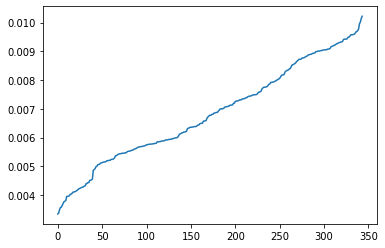

In [44]:
plt.plot(sorted(victim))

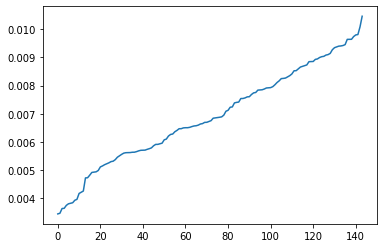

In [45]:
plt.plot(sorted(adv))

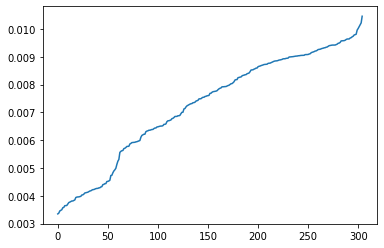

In [29]:
plt.plot(sorted(np.concatenate(month_wise[3:])))

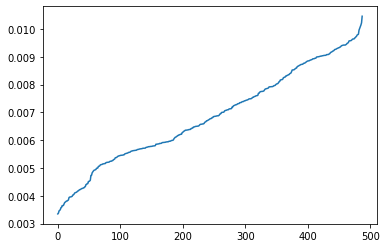

In [9]:
plt.plot(sorted(values))

In [ ]:
graph_to_process = "all_graphs_octnovdec.hdf5"

In [ ]:
graphs = dd.io.load(os.path.join(prefix, graph_to_process))

In [ ]:
def overlay_botnet_on_graph(graph, botnet_edges):
    # select evil node randomly
    evil_edges = np.array(botnet_edges).T
    evil_original = list(
        set(evil_edges[0, :].tolist()+evil_edges[1, :].tolist()))
    num_evil = len(evil_original)
    evil = random.sample(range(graph.number_of_nodes()), num_evil)

    evil_dict = {evil_original[i]: evil[i] for i in range(num_evil)}
    for row in range(evil_edges.shape[0]):
        for col in range(evil_edges.shape[1]):
            evil_edges[row, col] = evil_dict[evil_edges[row, col]]

    return evil_edges, evil

In [ ]:
def chord(num_node, num_edge, interval):
    edge = [[i % num_node, (i+1) % num_node]for i in range(num_node)]

    fingers = [x for x in range(0, num_node, interval)]
    for (i, finger) in enumerate(fingers):
        for j in range(i+1, len(fingers)):
            edge.append([finger, fingers[j]])

    edge_select = random.sample(edge, num_edge)
    return np.array(edge_select)

In [ ]:
def generate_botnet_graph(graph, num_node, num_edge, interval):
    # Generate botnet edges
    botnet_edges = chord(num_node, num_edge, interval)

    # Overlay botnets on graph
    evil_edges, evil = overlay_botnet_on_graph(graph, botnet_edges)
    graph.add_edges_from(evil_edges.T)

    # Create node labels
    y = np.zeros(graph.number_of_nodes())
    y[evil] = 1

    return (graph, y)

In [ ]:
processed_graphs = {}

In [ ]:
def pre_process_graph(graph, num_node, num_edge, interval):

    # Overlay botnet
    graph, label = generate_botnet_graph(graph, num_node, num_edge, interval)

    # Convert to DGL graph, assign features and labels
    dg_graph = dgl.from_networkx(graph)

    # Convert to undirected
    dg_graph = dgl.to_bidirected(dg_graph)

    # Add self loops
    dg_graph = dgl.transform.add_self_loop(dg_graph)

    # Add node features
    features = ch.ones(dg_graph.num_nodes(), self.num_features,)
    dg_graph.ndata['x'] = features

    # Add labels
    dg_graph.ndata['y'] = ch.from_numpy(label)

    return dg_graph

In [ ]:
b_size = 1000
b_interval = 2

In [ ]:
for n,g in tqdm(graphs.items()):
    processed_graphs[n] = pre_process_graph(g, b_size, b_size, b_interval)

In [ ]:
# Save back processed version of graphs (sans features)
dd.io.save(os.path.join(prefix, "dgl_octnovdec.hdf5"), processed_graphs)

### Load all graphs files from memory

In [127]:
octnovdec = dd.io.load(os.path.join(prefix, "dgl_octnovdec.hdf5"))

In [128]:
julaugsep = dd.io.load(os.path.join(prefix, "dgl_julaugsep.hdf5"))

In [129]:
mayjune = dd.io.load(os.path.join(prefix, "dgl_mayjune.hdf5"))

In [130]:
all_of_em = {**mayjune, **julaugsep, **octnovdec}

In [137]:
# Get victim-chosen graphs
victim_graphs = {x[1:]:all_of_em[x[1:]] for x in victim_names}
# Get adv-chosen graphs
adv_graphs = {x[1:]:all_of_em[x[1:]] for x in adv_names}
len(victim_graphs) + len(adv_graphs) == len(all_of_em)

In [145]:
# Save victim split
dgl.save_graphs(os.path.join(prefix, "dgl_victim.hdf5"), list(victim_graphs.values()))
# Save adv split
dgl.save_graphs(os.path.join(prefix, "dgl_adv.hdf5"), list(adv_graphs.values()))

In [152]:
# Save names of graphs (and their corresponding coefficient values)
names_victim = list(victim_graphs.keys())
names_adv = list(adv_graphs.keys())

In [156]:
def write_to_file(content, name):
    with open(name, 'w') as f:
        for c in content:
            f.write(c + "," + str(nam_val_map["/" + c]) + "\n")

In [158]:
write_to_file(names_victim, "./victim_info.txt")
write_to_file(names_adv, "./adv_info.txt")